In [1]:
import pyarrow.parquet as pq
import pandas as pd

In [2]:
prom_file_path = "/mnt/sdc/xiaoyu/prom_extr_att.parquet"

In [3]:
data = pd.read_parquet(prom_file_path)

In [4]:
#Group the data by 'timestamp' and 'node', and aggregate the 'power_consumption'

grouped_data = data.groupby(['timestamp'])['surfsara_power_usage'].sum().reset_index()

#The 'grouped_data' DataFrame now contains the power consumption for each node for each timestamp
grouped_data.head()

,timestamp,surfsara_power_usage
0,2022-06-30 16:00:30,32212.0
1,2022-06-30 16:01:00,32288.0
2,2022-06-30 16:01:30,32288.0
3,2022-06-30 16:02:00,32288.0
4,2022-06-30 16:02:30,32288.0


In [5]:
# grouped_data = grouped_data[grouped_data['node'] == 'r10n1']

In [6]:
## clean up data

# parses 'node' strings like r12n[1-30,32] to r12n1, r12n2 ... r12n30, r12n32  
def split_nodes(s):
    if s is None or len(s) == 0:
        return set()
    
    s = s.replace("\r\n", "").replace("\n", "").replace("\t", "")

    start = 0
    index = 0
    rack_chunks = []
    in_bracket = False
    while index < len(s):  # Separate them in parts like r12n[1-30,32] or r13n1
        if s[index] == "[":
            in_bracket = True
        elif s[index] == "]":
            in_bracket = False
        elif s[index] == "," and not in_bracket:
            rack_chunks.append(s[start: index])
            start = index + 1
        index += 1
    rack_chunks.append(s[start: index])  # Add the last line
    
    node_names = set()

    for rack_chunk in rack_chunks:
        if "[" in rack_chunk:
            prefix, postfix = rack_chunk.split("[")
            postfix = postfix[:-1]  # Remove the last bracket
            nodes = postfix.split(",")
            for node in nodes:
                if "-" in node:
                    start, end = node.split("-")
                    if not start.isnumeric() or not end.isnumeric():
                        continue
                    for i in range(int(start), int(end) + 1):
                        node_names.add("{}{}".format(prefix, i))
                else:
                    node_names.add("{}{}".format(prefix, node))
        else:
            node_names.add(rack_chunk)

    return node_names


# Creates a column that indicates if a job was executed on ML nodes
gpu_nodes = {
    "r28n1", "r28n2", "r28n3", "r28n4", "r28n5",
    "r29n1", "r29n2", "r29n3", "r29n4", "r29n5",
    "r30n1", "r30n2", "r30n3", "r30n4", "r30n5", "r30n6", "r30n7",
    "r31n1", "r31n2", "r31n3", "r31n4", "r31n5", "r31n6"
    "r32n1", "r32n2", "r32n3", "r32n4", "r32n5", "r32n6", "r32n7",
    "r33n2", "r33n3", "r33n5", "r33n6",
    "r34n1", "r34n2", "r34n3", "r34n4", "r34n5", "r34n6", "r34n7",
    "r35n1", "r35n2", "r35n3", "r35n4", "r35n5",
    "r36n1", "r36n2", "r36n3", "r36n4", "r36n5",
    "r38n1", "r38n2", "r38n3", "r38n4", "r38n5",
}

def mark_ml_data(df):
    node_type_l = []
    for i in df["split_nodes"]:
        if any(n in gpu_nodes for n in i):
            node_type = 1 # 1: ml jobs
        else: 
            node_type = 0 # 0: generic jobs
        node_type_l.append(node_type)
    df["node_type"] = node_type_l

# def mark_course_data(df):
#     for i in df.index:
#         if "course" in df["nodetypes"].iloc[i]: df["node_type"].iloc[i] = 2
#         if "education" in df["nodetypes"].iloc[i]: df["node_type"].iloc[i] = 2

# def calculate_perjob(row):
#     nodes = row["node"]
#     splitnodes = split_nodes(nodes)
#     return any([n in gpu_nodes for n in splitnodes])

# pandarallel.initialize(nb_workers=min(cpu_count(), 8), progress_bar=True)
# data["is_gpu"] =  data.parallel_apply(calculate_perjob, axis=1)


split_nodes_ls = []
for s in data['node']:
    split_nodes_ls.append(split_nodes(s))
data["split_nodes"] = split_nodes_ls
 
mark_ml_data(data)



In [7]:
data['rack'] = data['node'].str[:4]

data.rename(columns={'node_type': 'type'}, inplace=True)

data.head()

,id,timestamp,node,node_time_seconds,node_load15,surfsara_power_usage,up,node_netstat_Tcp_OutSegs,node_netstat_Tcp_InErrs,node_context_switches_total,...,node_udp_queues-sum,node_network_receive_bytes_total-sum,node_network_receive_packets_total-sum,node_network_receive_multicast_total-sum,node_disk_io_now-sum,node_rapl_package_joules_total-sum,node_network_receive_drop_total-sum,split_nodes,type,rack
0,23499351,2022-08-01 23:00:30,r12n20,1.659390e+09,3.25,180.0,1.0,8.229440e+09,0.0,2.358430e+10,...,0.0,3.904484e+13,8.240601e+09,1.0,0.0,95773.30,0.0,{r12n20},0,r12n
1,24679115,2022-08-01 23:00:30,r10n1,1.659390e+09,16.04,136.0,1.0,4.435130e+09,0.0,4.385200e+10,...,0.0,1.629571e+13,4.457970e+09,2.0,0.0,246806.22,0.0,{r10n1},0,r10n
2,24681081,2022-08-01 23:00:30,r10n2,1.659390e+09,16.06,184.0,1.0,1.333230e+10,0.0,6.533210e+10,...,0.0,6.950092e+13,1.388512e+10,2.0,0.0,215142.45,0.0,{r10n2},0,r10n
3,24683047,2022-08-01 23:00:30,r10n3,1.659390e+09,10.05,160.0,1.0,7.411810e+09,0.0,3.398420e+10,...,0.0,4.388573e+13,7.515447e+09,2.0,0.0,180487.40,0.0,{r10n3},0,r10n
4,24685012,2022-08-01 23:00:30,r10n4,1.659390e+09,16.07,152.0,1.0,3.827420e+09,0.0,5.320250e+10,...,0.0,1.695007e+13,3.949527e+09,2.0,0.0,143603.09,0.0,{r10n4},0,r10n


In [8]:
# Create a function that will help in classifying the nodes
def classify_node(node_name):
    if node_name.startswith(('r29n','r28n','r30n', 'r31n','r32n', 'r33n','r34n','r35n','r36n','r37n','r38n')):  # Include all specific node name beginnings that should be classified as 'ML'
        return 'ML'
    else:
        return 'Generic'

# Apply the function to the 'rack' column and store the result in the 'type' column
data['type'] = data['rack'].apply(classify_node)


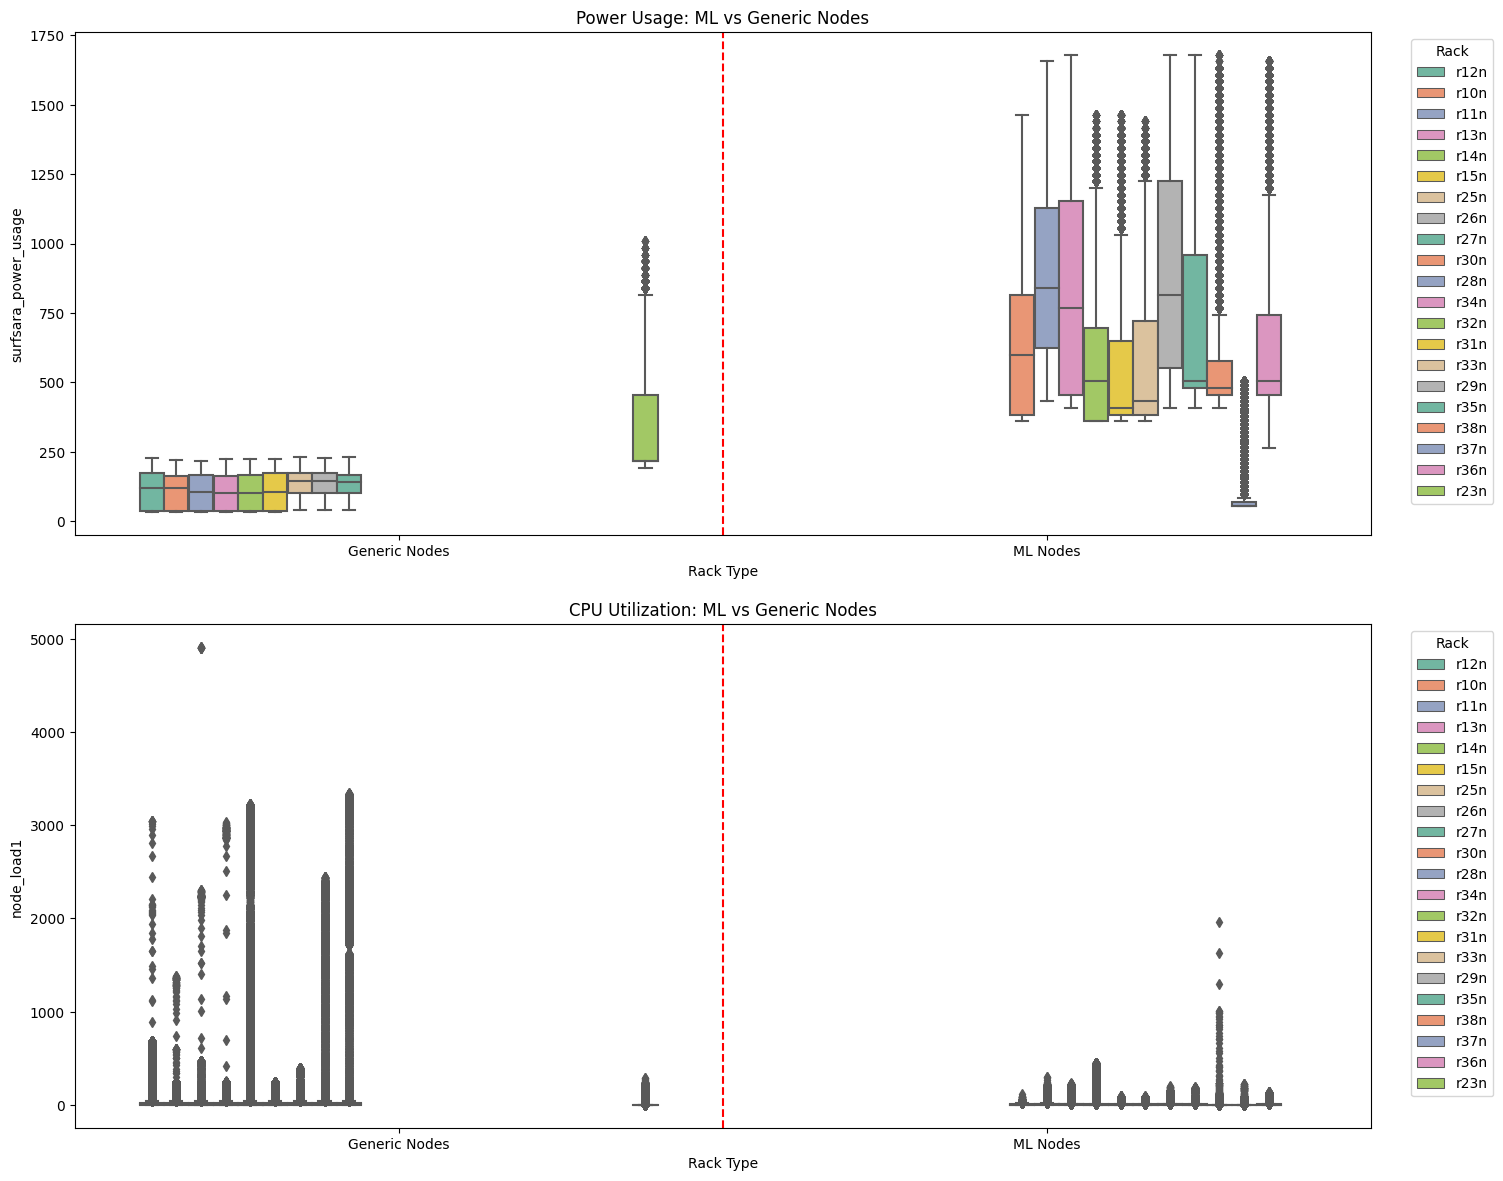

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Plot power usage for ML vs Generic Nodes with different colors for different racks
power_plot = sns.boxplot(x='type', y='surfsara_power_usage', hue='rack', data=data, ax=axes[0], palette='Set2')
axes[0].set_title('Power Usage: ML vs Generic Nodes')
axes[0].set_xlabel('Rack Type') # Setting x-axis label
axes[0].axvline(0.5, color='red', linestyle='--') # Adding vertical line

# Add a legend title and modify x-axis labels for the power usage plot
power_plot.legend(title='Rack', loc='upper right', bbox_to_anchor=(1.1, 1.0))
power_plot.set_xticklabels(['Generic Nodes', 'ML Nodes'])

# Plot CPU utilization for ML vs Generic Nodes with different colors for different racks
cpu_plot = sns.boxplot(x='type', y='node_load1', hue='rack', data=data, ax=axes[1], palette='Set2')
axes[1].set_title('CPU Utilization: ML vs Generic Nodes')
axes[1].set_xlabel('Rack Type') # Setting x-axis label
axes[1].axvline(0.5, color='red', linestyle='--') # Adding vertical line

# Add a legend title and modify x-axis labels for the CPU utilization plot
cpu_plot.legend(title='Rack', loc='upper right', bbox_to_anchor=(1.1, 1.0))
cpu_plot.set_xticklabels(['Generic Nodes', 'ML Nodes'])

# Display the plots
plt.tight_layout()
plt.show()

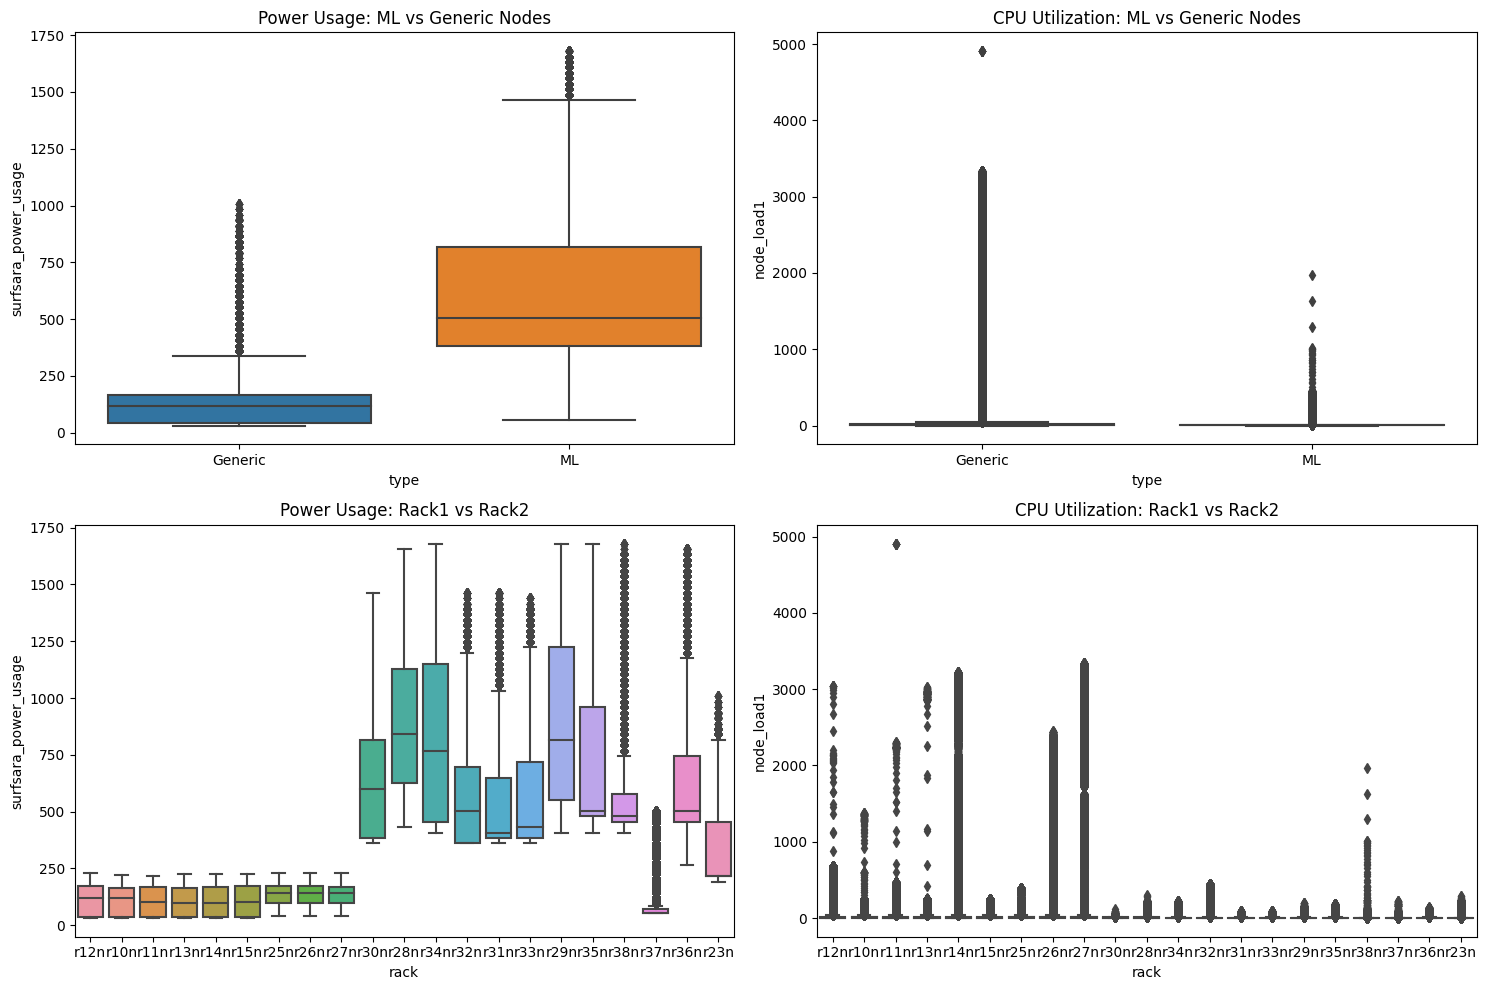

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot the comparison between ML nodes and generic nodes
sns.boxplot(x='type', y='surfsara_power_usage', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Power Usage: ML vs Generic Nodes')

sns.boxplot(x='type', y='node_load1', data=data, ax=axes[0, 1])
axes[0, 1].set_title('CPU Utilization: ML vs Generic Nodes')

# Plot the comparison between the two racks
sns.boxplot(x='rack', y='surfsara_power_usage', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Power Usage: Rack1 vs Rack2')

sns.boxplot(x='rack', y='node_load1', data=data, ax=axes[1, 1])
axes[1, 1].set_title('CPU Utilization: Rack1 vs Rack2')

# Display the plots
plt.tight_layout()
plt.show()


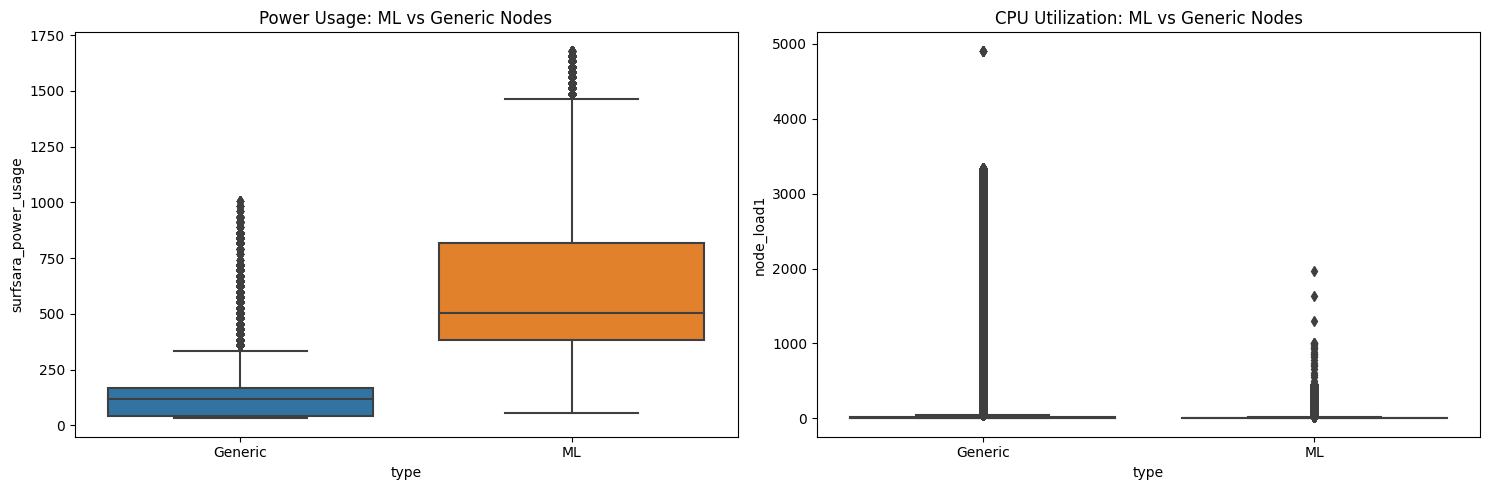

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the comparison between ML nodes and generic nodes
sns.boxplot(x='type', y='surfsara_power_usage', data=data, ax=axes[0])
axes[0].set_title('Power Usage: ML vs Generic Nodes')

sns.boxplot(x='type', y='node_load1', data=data, ax=axes[1])
axes[1].set_title('CPU Utilization: ML vs Generic Nodes')

# Display the plots
plt.tight_layout()
plt.show()
